# Estimate the number of infants (children under 1 year old)


Estimate the number of infants (children under 1 year old) to use for heatwave exposure. Evidence points to high vulnerability for newborns that drops rapidly until 5 years old, so it's not sensible to use the 0-5 age band as a whole - instead, need to estimate the spatial distribution of number of newborns per year.

GPWv4 gives demographic data per pixel by 5 year age band. Already estimated the time evolution using the WPP per country per year data (conveniant that GPW is already WPP adjusted so they fit).

Now want to estimate population of age zero witin the 0-4 age band.

Naive implementation is to divide by 5, but that would miss the large variation in infant mortality.

WPP has birthrates + IMR per country but for 5-year periods. Aim to estimate from this what proportion of under-5s are under-1, per country. Then assume a uniform spatial distribution, which is not super accurate but the best i can do without sub-national data (frankly this is a job for WHO bods to figure out, esp i geocoded their shit).


Several indicators in 5-year periods, from 1950-1955 to 2095-2100.

    TFR: Total fertility (live births per woman)
    NRR *: Net reproduction rate (surviving daughters per woman)
    CBR: Crude birth rate (births per 1,000 population)
    Births: Number of births, both sexes combined (thousands)
    LEx: Life expectancy at birth for both sexes combined (years)
    LExMale: Male life expectancy at birth (years)
    LExFemale: Female life expectancy at birth (years)
    IMR: Infant mortality rate, q(1), for both sexes combined (infant deaths per 1,000 live births)
    Q5: Under-five mortality, 5q0, for both sexes combined (deaths under age five per 1,000 live births)
    CDR: Crude death rate (deaths per 1,000 population)
    Deaths: Number of deaths, both sexes combined (thousands)
    DeathsMale *: Number of male deaths (thousands)
    DeathsFemale *: Number of female deaths (thousands)
    CNMR *: Net migration rate (per 1,000 population)
    NetMigrations *: Net number of migrants, both sexes combined (thousands)
    GrowthRate: Average annual rate of population change (percentage)
    NatIncr: Rate of natural increase (per 1,000 population)
    SRB *: Sex ratio at birth (male births per female births)
    MAC: Female mean age of childbearing (years)
    
    
**IMPORTANT:** a lot of the indicator units are misleadingly simple. e.g. Crude Birth Rate sounds like birth/pop/year but actually defined as "Number of births over a given period divided by the person-years lived by the population over that period." I think this is supposed correspond to what layperson would think of as 'birth over population' but taking into account more complicated part of what the 'population' means over a continuous 5-year time period (since you have further birth/death in that time). Clearly extra modelling was involved.

**QUESTION:** is it better to the use total Births per 5-year time period and assume and average of Birth/5 births per year for the calculation. OR to use CBR (which already involves some adjustments for mess of data) and multiply by total population per year from my other data?
=> I think the latter, better to work in terms of rates applied to another dataset, i.e. I get the rate from WPP but use the GPW pop in order to stay consistent with the GPW abosolute numbers.



In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from config import POP_DATA_SRC, DATA_SRC

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

In [2]:
UN_DEMOGRAPHICS_FILE  = POP_DATA_SRC / 'UN' / 'WPP2019_PopulationByAgeSex_Medium.csv'

UN_LIFE_INDICATORS_FILE  = POP_DATA_SRC / 'UN' / 'WPP2019_Period_Indicators_Medium.csv'
    
COUNTRY_ID_LOOKUP = DATA_SRC/ 'lancet/population/gpwv4/gpw-v4-basic-demographic-characteristics-rev11_bt_cntm_15_min_nc/gpw_v4_national_identifier_grid_rev11_lookup.txt'


In [3]:
GPW_DATA_FILE= DATA_SRC/ 'lancet/population/UN WPP-Adjusted Population Count v4.11 2000-2020 15min era compat.nc'

In [4]:
COUNTRIES_LOOKUP = pd.read_csv(COUNTRY_ID_LOOKUP,sep='\t')

In [5]:
COUNTRIES_LOOKUP.head()

Value ISOCODE  UNSDCODE           NAME0  CIESINCODE  \
0      4     AFG         4     Afghanistan           4   
1      8     ALB         8         Albania           8   
2     12     DZA        12         Algeria          12   
3     16     ASM        16  American Samoa          16   
4     20     AND        20         Andorra          20   

                         DATATYPE  DATACODE  DATAYEAR  DATALEVEL  SEXLEVEL  \
0  Population estimate/projection         6      2011          2         2   
1                    Final census         1      2011          3         1   
2                    Final census         1      2008          2         2   
3                    Final census         1      2010          3         3   
4             Population register         5      2010          1         1   

   AGELEVEL  GRSTART  GREND  GRLEVEL  LASTCENSUS    MEANUNITKM  
0         0     1998   2011        1        1979   4507.466751  
1         1     2001   2011        3        2011    115.949835  
2         2     1998   2008        2        2008  50884.794880  
3         3     2000   2010        3        2010      7.612468  
4         1     2000   2010        1        2011     79.902822

## Load the UN WPP data

In [6]:
un_demog = pd.read_csv(UN_DEMOGRAPHICS_FILE)

In [7]:
un_life = pd.read_csv(UN_LIFE_INDICATORS_FILE)

In [8]:
un_life.IMR

0        275.866
1        253.647
2        230.194
3        211.072
4        191.642
          ...   
14935     13.632
14936     13.112
14937     12.691
14938     12.274
14939     11.863
Name: IMR, Length: 14940, dtype: float64

In [9]:
# No need to keep data all the way to 2100!
un_demog = un_demog[un_demog.Time < 2050]

un_life = un_life[un_life.MidPeriod < 2050]

In [10]:
un_demog.head()

LocID     Location  VarID Variant  Time  MidPeriod AgeGrp  AgeGrpStart  \
0      4  Afghanistan      2  Medium  1950     1950.5    0-4            0   
1      4  Afghanistan      2  Medium  1950     1950.5    5-9            5   
2      4  Afghanistan      2  Medium  1950     1950.5  10-14           10   
3      4  Afghanistan      2  Medium  1950     1950.5  15-19           15   
4      4  Afghanistan      2  Medium  1950     1950.5  20-24           20   

   AgeGrpSpan  PopMale  PopFemale  PopTotal  
0           5  630.044    661.578  1291.622  
1           5  516.206    487.335  1003.540  
2           5  461.378    423.326   884.704  
3           5  414.369    369.363   783.732  
4           5  374.109    318.392   692.501

In [11]:
un_life.head()

LocID     Location  VarID Variant       Time  MidPeriod   TFR    NRR  \
0      4  Afghanistan      2  Medium  1950-1955       1953  7.45  1.636   
1      4  Afghanistan      2  Medium  1955-1960       1958  7.45  1.765   
2      4  Afghanistan      2  Medium  1960-1965       1963  7.45  1.899   
3      4  Afghanistan      2  Medium  1965-1970       1968  7.45  2.017   
4      4  Afghanistan      2  Medium  1970-1975       1973  7.45  2.141   

      CBR    Births  ...     CDR    Deaths  DeathsMale  DeathsFemale   CNMR  \
0  50.314  2015.476  ...  36.862  1476.605     794.020       682.585 -0.499   
1  50.998  2201.589  ...  33.718  1455.605     783.110       672.495 -0.463   
2  51.477  2439.130  ...  30.808  1459.784     777.437       682.347 -0.422   
3  51.646  2728.221  ...  28.223  1490.896     790.745       700.151 -0.379   
4  51.234  3056.451  ...  25.495  1520.938     802.414       718.524 -0.335   

   NetMigrations  GrowthRate  NatIncr   SRB     MAC  
0          -20.0       1.296   13.452  1.06  29.835  
1          -20.0       1.683   17.280  1.06  29.835  
2          -20.0       2.026   20.669  1.06  29.835  
3          -20.0       2.307   23.423  1.06  29.835  
4          -20.0       2.544   25.739  1.06  29.835  

[5 rows x 25 columns]

## Load relevant variables from the GPW file

In [12]:
GPW_DATA = xr.open_dataset(GPW_DATA_FILE).load()

In [13]:
population = GPW_DATA['UN WPP-Adjusted Population Count, v4.11 (2000-2020)']

In [14]:
demog = GPW_DATA['Basic Demographic Characteristics, v4.11 (2010): Both, Count']

In [15]:
demog_pcts = GPW_DATA['Basic Demographic Characteristics, v4.11 (2010): Both, Percent']

In [16]:
countries_grid = GPW_DATA['National Identifier Grid, v4.11 (2010): National Identifier Grid']

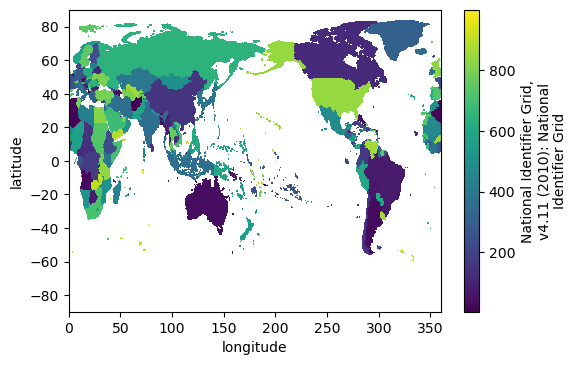

In [17]:
countries_grid.where(countries_grid < 3000 ).plot()

## Create an xarray ND dataset out of the UN tables

In [18]:
un_demog_xr = un_demog[['LocID', 'Time', 'AgeGrpStart',  'PopTotal']].set_index(['AgeGrpStart','LocID', 'Time']).sort_index().to_xarray()

# Sum the values above age 65 and assign to the age 65 band
un_demog_xr.PopTotal.loc[dict(AgeGrpStart=65)] = un_demog_xr.PopTotal.sel(AgeGrpStart=slice(65, None)).sum(dim='AgeGrpStart')
# Drop the age bands above 65
un_demog_xr = un_demog_xr.sel(AgeGrpStart=slice(65))
un_demog_xr = un_demog_xr.rename({'AgeGrpStart': 'age_band_lower_bound', 'Time': 'year'})

In [19]:
un_demog_xr

<xarray.Dataset>
Dimensions:               (LocID: 251, age_band_lower_bound: 14, year: 100)
Coordinates:
  * age_band_lower_bound  (age_band_lower_bound) int64 0 5 10 15 ... 50 55 60 65
  * LocID                 (LocID) int64 4 8 12 24 28 ... 1833 1835 5500 5501
  * year                  (year) int64 1950 1951 1952 1953 ... 2047 2048 2049
Data variables:
    PopTotal              (age_band_lower_bound, LocID, year) float64 1.292e+...

In [20]:
un_life_xr = un_life[['LocID',
                      'MidPeriod',
#                       'Time', 
                      'TFR',
       'NRR', 'CBR', 'Births', 'LEx', 'LExMale', 'LExFemale', 'IMR', 'Q5',
       'CDR', 'Deaths', 'DeathsMale', 'DeathsFemale', 'CNMR', 'NetMigrations',
       'GrowthRate', 'NatIncr', 'SRB', 'MAC']].set_index(['LocID', 'MidPeriod']).sort_index().to_xarray()

In [21]:
# Can make a periodindex but not sure it helps much
# un_life_xr['Time'] = pd.period_range(start='1950-01-01', end='2045-01-01', freq='5Y')
# un_life_xr['Time'] = pd.period_range(start='1950-01-01', end='2045-01-01', freq='5Y').to_timestamp()

In [22]:
un_life_xr

<xarray.Dataset>
Dimensions:        (LocID: 498, MidPeriod: 20)
Coordinates:
  * LocID          (LocID) int64 4 8 12 16 20 24 ... 2097 2098 2099 5500 5501
  * MidPeriod      (MidPeriod) int64 1953 1958 1963 1968 ... 2033 2038 2043 2048
Data variables:
    TFR            (LocID, MidPeriod) float64 7.45 7.45 7.45 ... 1.947 1.901
    NRR            (LocID, MidPeriod) float64 1.636 1.765 1.899 ... 0.907 0.888
    CBR            (LocID, MidPeriod) float64 50.31 51.0 51.48 ... 13.7 13.0
    Births         (LocID, MidPeriod) float64 2.015e+03 2.202e+03 ... 1.543e+05
    LEx            (LocID, MidPeriod) float64 28.61 31.13 33.74 ... 74.01 74.76
    LExMale        (LocID, MidPeriod) float64 27.94 30.43 32.99 ... 72.32 73.02
    LExFemale      (LocID, MidPeriod) float64 29.43 31.97 34.64 ... 75.85 76.65
    IMR            (LocID, MidPeriod) float64 275.9 253.6 230.2 ... 18.82 16.91
    Q5             (LocID, MidPeriod) float64 405.1 374.1 342.0 ... 23.09 20.73
    CDR            (LocID, MidPeriod) float64 36.86 33.72 30.81 ... 8.4 8.907
    Deaths         (LocID, MidPeriod) float64 1.477e+03 1.456e+03 ... 1.058e+05
    DeathsMale     (LocID, MidPeriod) float64 794.0 783.1 ... 5.729e+04
    DeathsFemale   (LocID, MidPeriod) float64 682.6 672.5 ... 4.847e+04
    CNMR           (LocID, MidPeriod) float64 -0.499 -0.463 ... -0.487 -0.476
    NetMigrations  (LocID, MidPeriod) float64 -20.0 -20.0 ... -5.649e+03
    GrowthRate     (LocID, MidPeriod) float64 1.296 1.683 2.026 ... 0.482 0.361
    NatIncr        (LocID, MidPeriod) float64 13.45 17.28 20.67 ... 5.303 4.09
    SRB            (LocID, MidPeriod) float64 1.06 1.06 1.06 ... 1.08 1.08 1.08
    MAC            (LocID, MidPeriod) float64 29.84 29.84 29.84 ... 28.07 28.23

# Project birth rates

> PRoblem: doing the naive way of upsampling the CBR to yearly and then mult by pop gives a horrible 'sawtooth' birth per year sum, probably something to do with the population growing in the 5 year period and you 'double count' the births because the pop increase is from the birth rates but you also mult by the birth rate. I think the rigth way to do it is to apply the birth rate per pixel by 5-year band and then evenly re-distribute back to the individual years, which should result in more a 'step' than a sawtooth - not idea but at least not as obviously wrong!


OK actually new way, from looking at the sawtooth - i think the birth = CBR* pop is correct at the start of the 5 year periods, so instead just calculate it for those times and then linearly interpolate!


Upsample Birth rate (CBR)

Upsample the CBR to yearly to match with the population data. Note that we don't do this for all vars because not all of them make sense to upsample - keep this explicit. Use upsample and forward fill to copy the CBR for each year in the 5-year period. Note that I tried to do this properly using the period index but didn't seem to work, in the end using datetime index with the 1st year of the period worked fine except that doesn't generate the last 5-year but that's to 2050 so doesnt matter.





## Estimate the distribution of newborns by:

Get the gridded number of under 5s for each country

Calculate a gridded weight by dividing by the sum of the under 5s for each country-> using the GPW data so just for 2010

$\Sigma w_i * c_i = c_{total}$ 
$\Sigma w_i = 1$ 


Calculate the total number of newborns for a country as CBR * country pop (technically should be related to the total Births value, but the latter seems to be total over 5 years so anyway need to dick about to estimate for one year)

Calculate the gridded number of newborns per cell using the weights 

$w_i * b$



## Correct for infant mortality rate

IMR is given as the deaths per 1000 *births* while CBR is births per 1000 pop.

Need to first calculate total births then reduce by the %IMR -> don't forget to convert IMR to fraction


births = country_pop * CBR

deaths = IMR * births

infants = births - deaths = country_pop * CBR - IMR * births = country_pop * CBR - IMR *  country_pop * CBR = country_pop * CBR * (1 - IMR)

In [23]:
un_births = un_life_xr.CBR

In [24]:
un_imr = un_life_xr.IMR.rename({ 'MidPeriod': 'year'})

In [25]:
# un_births['Time'] = pd.date_range('1950-01-01', '2050-01-01', freq='5Y')
# un_births['Time']  = np.arange(1950, 2050, 5)
# un_births = un_births.rename({ 'Time': 'year'})
un_births = un_births.rename({ 'MidPeriod': 'year'})

In [26]:
# population['year'] = pd.date_range('2000-01-01', '2021-01-01', freq='Y')

In [27]:
years_with_birth_and_pop = sorted(list(set(un_births.year.data).intersection(set(population.year.data))))

pop_5yr = population.sel(year=years_with_birth_and_pop)
un_birth_5yr = un_births.sel(year=years_with_birth_and_pop)
un_imr_5yr = un_imr.sel(year=years_with_birth_and_pop)

In [28]:
un_imr_5yr

<xarray.DataArray 'IMR' (LocID: 498, year: 4)>
array([[84.647, 72.193, 60.1  , 51.707],
       [21.153, 16.781,  9.212,  8.026],
       [33.62 , 29.398, 24.94 , 21.243],
       ...,
       [25.7  , 23.089, 20.456, 17.962],
       [47.148, 36.559, 26.381, 20.562],
       [61.537, 51.656, 42.352, 35.901]])
Coordinates:
  * LocID    (LocID) int64 4 8 12 16 20 24 28 ... 2096 2097 2098 2099 5500 5501
  * year     (year) int64 2003 2008 2013 2018

In [1]:
# ## Prepare a results dataset with all the coordinates (space, time, age band)
# results = xr.DataArray(
#     np.zeros((
#         len(demog_pcts.latitude), 
#         len(demog_pcts.longitude), 
#         len(un_birth_5yr.year))), 
#     coords=[
#         demog_pcts.latitude,
#         demog_pcts.longitude, 
#         un_birth_5yr.year
#     ]
# )

# for _, row in tqdm(COUNTRIES_LOOKUP.iterrows(), total=len(COUNTRIES_LOOKUP)):
#     # iterate countries from the lookup table but make sure they are actually in the data file
#     if row.UNSDCODE in un_life_xr.LocID:
#         grid_code = row.CIESINCODE
#         country_mask = countries_grid == grid_code
#         country_pop = pop_5yr.where(country_mask)
                    
#         # get the birth rate as a fraction of total population
#         # convert the CBR from per 1000 pop to per 1 pop
#         country_births = un_birth_5yr.sel(LocID=row.UNSDCODE).drop('LocID') / 1000
#         # Calculate the gridded value by adjusting the 2010 grid using the ratio above
#         country_births = country_births * country_pop
#         results = xr.where(country_mask, country_births, results)
# # Replace empty cells with nan
# results = results.where(pop_5yr > 0)
# birth_gridded = results.interp(year=(np.arange(2000, 2021)), kwargs=dict(fill_value="extrapolate"))


In [30]:
## Prepare a results dataset with all the coordinates (space, time, age band)
results = xr.DataArray(
    np.zeros((
        len(demog_pcts.latitude), 
        len(demog_pcts.longitude), 
        len(un_birth_5yr.year))), 
    coords=[
        demog_pcts.latitude,
        demog_pcts.longitude, 
        un_birth_5yr.year
    ]
)

for _, row in tqdm(COUNTRIES_LOOKUP.iterrows(), total=len(COUNTRIES_LOOKUP)):
    # iterate countries from the lookup table but make sure they are actually in the data file
    if row.UNSDCODE in un_life_xr.LocID:
        grid_code = row.CIESINCODE
        country_mask = countries_grid == grid_code
        country_pop = pop_5yr.where(country_mask)
        country_under_5 = demog.sel(age_band_lower_bound=0).where(country_mask)
        country_under_5_weights = country_under_5 / country_under_5.sum()
        try:
            assert np.abs(country_under_5_weights.sum() -1) < 1e-5
        except AssertionError:
            print('no data for: ', row.NAME0)
            continue
                    
        # get the birth rate as a fraction of total population
        # convert the CBR from per 1000 pop to per 1 pop
#         country_births = (country_pop.sum(dim=['latitude', 'longitude']) 
#                           * un_birth_5yr.sel(LocID=row.UNSDCODE).drop('LocID') / 1000
#                           * country_under_5_weights
#                          )
        country_cbr = un_birth_5yr.sel(LocID=row.UNSDCODE).drop('LocID') / 1000
        country_imr = un_imr_5yr.sel(LocID=row.UNSDCODE).drop('LocID') / 1000
        
        country_infants = (country_pop.sum(dim=['latitude', 'longitude']) 
                  * country_cbr * (1 - country_imr)
                  * country_under_5_weights
                 )
        
        # Calculate the gridded value by adjusting the 2010 grid using the ratio above
        results = xr.where(country_mask, country_infants, results)
# Replace empty cells with nan
results = results.where(pop_5yr > 0)
infants_gridded = results.interp(year=(np.arange(2000, 2021)),kwargs=dict(fill_value="extrapolate"))


  0%|          | 0/248 [00:00<?, ?it/s]

no data for:  Andorra
no data for:  Gibraltar
no data for:  Holy See
no data for:  Liechtenstein
no data for:  China Macao Special Administrative Region
no data for:  Monaco
no data for:  San Marino


## Plot checks

Text(0, 0.5, 'millions')

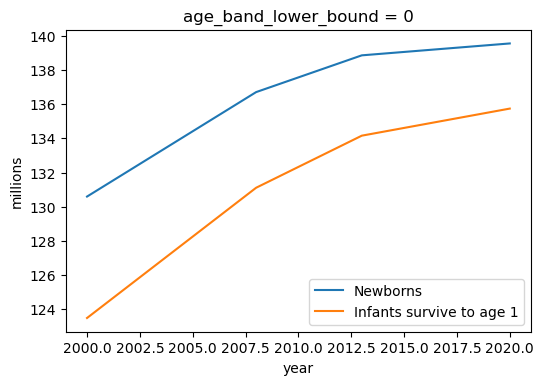

In [39]:
(birth_gridded.sum(dim=['latitude', 'longitude']) /1e6).plot(label='Newborns')
(infants_gridded.sum(dim=['latitude', 'longitude']) /1e6).plot(label='Infants survive to age 1')
plt.legend()
plt.ylabel('millions')

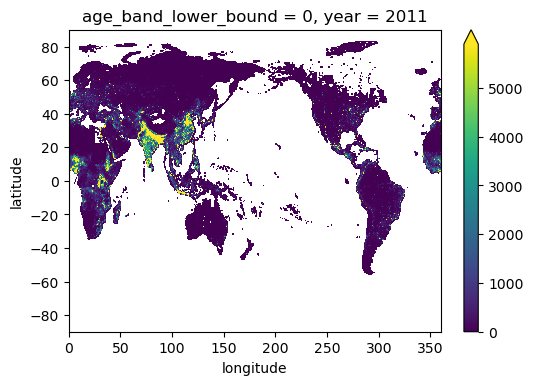

In [157]:
birth_gridded.sel(year=2011).plot(robust=True)

In [33]:
# (birth_gridded
#  .to_dataset(name='births')
#  .to_netcdf(POP_DATA_SRC / f'births_{birth_gridded.year.min().item()}_{birth_gridded.year.max().item()}_15_min_era_compat.nc',
#             encoding={'births': {'dtype': 'float32'}}
#            ))

In [53]:
(infants_gridded
 .to_dataset(name='infants')
 .to_netcdf(POP_DATA_SRC / f'infants_{infants_gridded.year.min().item()}_{infants_gridded.year.max().item()}_15_min_era_compat.nc',
            encoding={'infants': {'dtype': 'float32'}}
           ))

In [55]:
# infants_gridded

# Try to recover ISIMIP data by upsampling

Basically trying to do a wieghted assignment of the population in the low rez file to the high rez grid

Calculate the population density per grid cell using the GPW cell info, linear interpolate, then re-multiply by the high res grid cells

> **NOTE**: it seems this method works for the ISIMIP part of the data but introduces a systematic error for the GPW (post-2000) part. I think its best to present these together but seperately, can put everything into one file but need to remember to highlight that pre and post 2000 data has different quality.



In [56]:
POPULATION_FILE_LOWREZ = POP_DATA_SRC / 'population_ismip_and_gpw4_era_compat.nc'
AREA_FILE_LOWREZ = POP_DATA_SRC / 'land_mask_30min_era_compat.nc'

In [57]:
area_lowrez = xr.open_dataset(AREA_FILE_LOWREZ)

area_highrez = GPW_DATA['Land and Water Area, v4.11 (2010): Land Area']

population_lowrez = xr.open_dataarray(POPULATION_FILE_LOWREZ)

population_lowrez = population_lowrez.sel(year=slice(1950, None))

In [58]:
pop_per_area = population_lowrez / area_lowrez.land_water_area

In [59]:
# Population density per pixel is constant
pop_per_area = pop_per_area.interp_like(area_highrez)

In [60]:
population_interped = pop_per_area * area_highrez

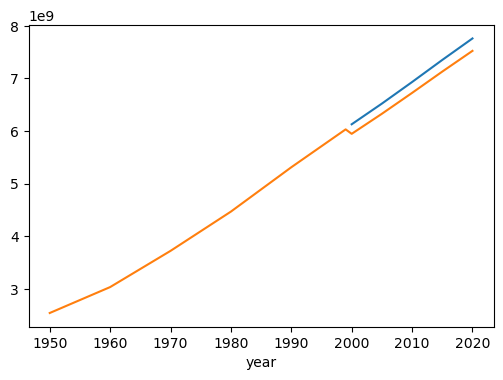

In [61]:
population.sum(dim=['latitude', 'longitude']).plot()
population_interped.sum(dim=['latitude', 'longitude']).plot()

# population_lowrez.sum(dim=['latitude', 'longitude']).plot()


In [62]:
check = np.abs(population - population_interped )

In [63]:
# check.mean(dim=['latitude', 'longitude']).plot()

**Keep only 1950-1999 corresponding to the ISIMIP part, get wierd artefacts when merging with GPW**

In [64]:
# population_interped.sel(year=slice(1950, 1999)).to_dataset(name='population').to_netcdf(
#     POP_DATA_SRC / 'population_ismip_interp_15_min_era_compat.nc',
#     encoding={'population': {'dtype': 'float32'}})

In [65]:
population_combo = xr.concat([population_interped.sel(year=slice(1950, 1999)), population], 'year')

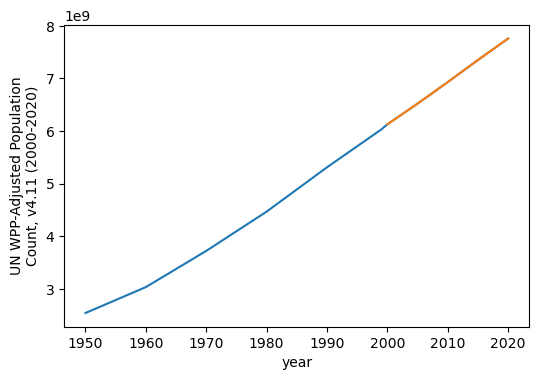

In [66]:
# population_interped.sum(dim=['latitude', 'longitude']).plot()
population_combo.sum(dim=['latitude', 'longitude']).plot()
population.sum(dim=['latitude', 'longitude']).plot()



In [67]:
years_with_birth_and_pop = sorted(list(set(un_births.year.data).intersection(set(population_combo.year.data))))

pop_5yr = population_combo.sel(year=years_with_birth_and_pop)
un_birth_5yr = un_births.sel(year=years_with_birth_and_pop)
un_imr_5yr = un_imr.sel(year=years_with_birth_and_pop)

In [39]:
# ## Prepare a results dataset with all the coordinates (space, time, age band)
# results = xr.DataArray(
#     np.zeros((
#         len(demog_pcts.latitude), 
#         len(demog_pcts.longitude), 
#         len(un_birth_5yr.year))), 
#     coords=[
#         demog_pcts.latitude,
#         demog_pcts.longitude, 
#         un_birth_5yr.year
#     ]
# )

# for _, row in tqdm(COUNTRIES_LOOKUP.iterrows(), total=len(COUNTRIES_LOOKUP)):
#     # iterate countries from the lookup table but make sure they are actually in the data file
#     if row.UNSDCODE in un_life_xr.LocID:
#         grid_code = row.CIESINCODE
#         country_mask = countries_grid == grid_code
#         country_pop = pop_5yr.where(country_mask)
                    
#         # get the birth rate as a fraction of total population
#         # convert the CBR from per 1000 pop to per 1 pop
#         country_births = un_birth_5yr.sel(LocID=row.UNSDCODE).drop('LocID') / 1000

#         # Calculate the gridded value by adjusting the 2010 grid using the ratio above
#         country_births = country_births * country_pop
#         results = xr.where(country_mask, country_births, results)
# # Replace empty cells with nan
# results = results.where(pop_5yr > 0)

In [68]:
## Prepare a results dataset with all the coordinates (space, time, age band)
results = xr.DataArray(
    np.zeros((
        len(demog_pcts.latitude), 
        len(demog_pcts.longitude), 
        len(un_birth_5yr.year))), 
    coords=[
        demog_pcts.latitude,
        demog_pcts.longitude, 
        un_birth_5yr.year
    ]
)

for _, row in tqdm(COUNTRIES_LOOKUP.iterrows(), total=len(COUNTRIES_LOOKUP)):
    # iterate countries from the lookup table but make sure they are actually in the data file
    if row.UNSDCODE in un_life_xr.LocID:
        grid_code = row.CIESINCODE
        country_mask = countries_grid == grid_code
        country_pop = pop_5yr.where(country_mask)
        country_under_5 = demog.sel(age_band_lower_bound=0).where(country_mask)
        country_under_5_weights = country_under_5 / country_under_5.sum()
        try:
            assert np.abs(country_under_5_weights.sum() -1) < 1e-5
        except AssertionError:
            print('no data for: ', row.NAME0)
            continue
                    
        # get the birth rate as a fraction of total population
        # convert the CBR from per 1000 pop to per 1 pop
#         country_births = (country_pop.sum(dim=['latitude', 'longitude']) 
#                           * un_birth_5yr.sel(LocID=row.UNSDCODE).drop('LocID') / 1000
#                           * country_under_5_weights
#                          )
        
        
        country_cbr = un_birth_5yr.sel(LocID=row.UNSDCODE).drop('LocID') / 1000
        country_imr = un_imr_5yr.sel(LocID=row.UNSDCODE).drop('LocID') / 1000

        
        country_infants = (country_pop.sum(dim=['latitude', 'longitude']) 
                  * country_cbr * (1 - country_imr)
                  * country_under_5_weights
                 )
        # Calculate the gridded value by adjusting the 2010 grid using the ratio above
        results = xr.where(country_mask, country_infants, results)
# Replace empty cells with nan
results = results.where(pop_5yr > 0)

  0%|          | 0/248 [00:00<?, ?it/s]

no data for:  Andorra
no data for:  Gibraltar
no data for:  Holy See
no data for:  Liechtenstein
no data for:  China Macao Special Administrative Region
no data for:  Monaco
no data for:  San Marino


In [69]:
# birth_gridded_hybrid = results.interp(
#     year=np.arange(1950, 2021), kwargs=dict(fill_value="extrapolate"))

In [70]:
infants_gridded_hybrid = results.interp(
    year=np.arange(1950, 2021), kwargs=dict(fill_value="extrapolate"))

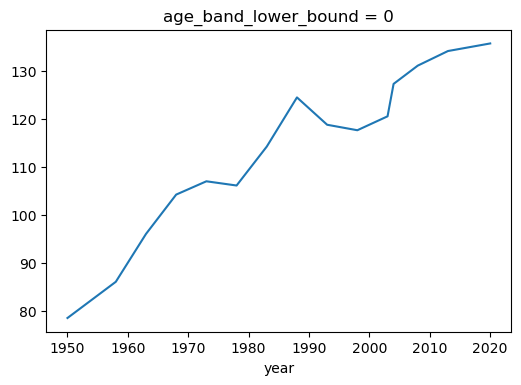

In [71]:
(infants_gridded_hybrid.sum(dim=['latitude', 'longitude']) /1e6).plot()


In [52]:
# (birth_gridded_hybrid
#  .to_dataset(name='births')
#  .to_netcdf(POP_DATA_SRC / f'births_{birth_gridded_hybrid.year.min().item()}_{birth_gridded_hybrid.year.max().item()}_hybrid_15_min_era_compat.nc',
#             encoding={'births': {'dtype': 'float32'}}
#            ))

In [73]:
(infants_gridded_hybrid
 .to_dataset(name='infants')
 .to_netcdf(POP_DATA_SRC / f'infants_{infants_gridded_hybrid.year.min().item()}_{infants_gridded_hybrid.year.max().item()}_hybrid_15_min_era_compat.nc',
            encoding={'infants': {'dtype': 'float32'}}
           ))

In [53]:
f'births_{birth_gridded_hybrid.year.min().item()}_{birth_gridded_hybrid.year.max().item()}_hybrid_15_min_era_compat.nc'

'births_1950_2020_hybrid_15_min_era_compat.nc'

In [47]:
birth_gridded_hybrid.year.max().item()

2020